In [51]:
import os
import pathlib
import re
import copy
import warnings
import time
import json
import pickle

from sklearn import svm
from sys import getsizeof
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import gamma
from sklearn.preprocessing import MinMaxScaler

import cv2
import xmltodict
import numpy as np
import pandas as pd
import tiffcapture as tc

from tifffile import imsave
from matplotlib import pyplot as pt

%matplotlib inline

In [15]:
def stringify_position(position):
    
    if position < 10:
        pos = "0%d" % position
    else:
        pos = str(position)
        
    return pos

In [3]:
dat_f = pickle.load(open("../results/unsyn_filtered_data_divided_before_treatment.p", "rb"))
dat_ds = pickle.load(open("../results/unsyn_filtered_data_pi_sub.p", "rb"))

process in following part does not work that well due to the ambiguouity. For analysis purpose only singly placed cells should be integrated with PI data. Do this after the program ran

In [6]:
# ## create reverse lookup for slit in PI video

# slit_tree_map_ds = {}

# for pos in dat_ds:
#     slit_tree_map_ds[pos] = {}
#     for tr in dat_ds[pos]['TREES']:
#         slit_id = dat_ds[pos]['TREES'][tr]['SLIT_ID']
#         if slit_id not in slit_tree_map_ds[pos]:
#             slit_tree_map_ds[pos][slit_id] = [tr]
#         else:
#             slit_tree_map_ds[pos][slit_id].append(tr)
            
# ## create reverse lookup for slit in BF video
# slit_tree_map_bf = {}

# for pos in dat_f:
#     slit_tree_map_bf[pos] = {}
#     for tr in dat_f[pos]['TREES']:
#         slit_id = dat_f[pos]['TREES'][tr]['SLIT_ID']
#         if slit_id not in slit_tree_map_bf[pos]:
#             slit_tree_map_bf[pos][slit_id] = [tr]
#         else:
#             slit_tree_map_bf[pos][slit_id].append(tr)
            
# ## integrade cell death signal information into brightfield data

# correlation_analysis = {}
# ttd_analysis = {}
# ttd_analysis_double = {}

# for pos in slit_tree_map_ds.keys():
#     correlation_analysis[pos] = []
#     ttd_analysis[pos] = []
#     ttd_analysis_double[pos] = []
#     for slit_id in slit_tree_map_ds[pos]:
#         if slit_id in slit_tree_map_bf[pos]:
            
#             ## double track == TTD and correlation
#             if len(slit_tree_map_ds[pos][slit_id]) == 2:
                
#                 # extract div time from BF tree
#                 tr = slit_tree_map_bf[pos][slit_id][0]
# #                 tr_div_time = dat_fat[pos]['TREES'][tr]['POSITION_T'][tr][-1]
#                 tr_div_time = dat_f[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                
#                 # extract death time from DS tree I and II
#                 tr_ds_1 = slit_tree_map_ds[pos][slit_id][0]
#                 tr_ds_2 = slit_tree_map_ds[pos][slit_id][1]
#                 tr_death_time_1 = dat_ds[pos]['TREES'][tr_ds_1]['POSITION_T'][tr_ds_1][1]
#                 tr_death_time_2 = dat_ds[pos]['TREES'][tr_ds_2]['POSITION_T'][tr_ds_2][1]
#                 correlation_analysis[pos].append((tr_div_time, tr_death_time_1, tr_death_time_2))
#                 ttd_analysis[pos].append((tr_div_time, tr_death_time_1))
#                 ttd_analysis[pos].append((tr_div_time, tr_death_time_2))
#                 ttd_analysis_double[pos].append((tr_div_time, tr_death_time_1))
#                 ttd_analysis_double[pos].append((tr_div_time, tr_death_time_2))
                
#             elif len(slit_tree_map_ds[pos][slit_id]) == 1:
                
#                 # extract div time from BF tree
#                 tr = slit_tree_map_bf[pos][slit_id][0]
# #                 tr_div_time = dat_fat[pos]['TREES'][tr]['POSITION_T'][tr][-1]
#                 tr_div_time = dat_f[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                
#                 # extract death time from DS tree
#                 tr_ds = slit_tree_map_ds[pos][slit_id][0]
#                 tr_death_time = dat_ds[pos]['TREES'][tr_ds]['POSITION_T'][tr_ds][1]
                
#                 ttd_analysis[pos].append((tr_div_time, tr_death_time))

In [39]:
dat_f[pos]['TREES'][t].keys()

dict_keys(['VELOCITY', 'TREE', 'CASPASE_SUB', 'CASPASE', 'POSITION_X', 'SLIT_ID', 'DISPLACEMENT', 'PI_SUB', 'PI_SUB_NORM', 'PI_NORM', 'POSITION_T', 'POSITION_Y', 'CASPASE_NORM', 'PI', 'BRANCH', 'CASPASE_SUB_NORM'])

In [287]:
invalid = set([4, 5, 11, 13, 19, 20, 37, 38, 44, 53, 54, 60])

X = np.array([])
y = np.array([])
for ps in set(list(range(64))[1:]) - invalid:

    pos = stringify_position(ps)
    
    for t in dat_f[pos]['TREES']:

        t_tree = dat_f[pos]['TREES'][t]
        t_branch = dat_f[pos]['TREES'][t]['BRANCH']

        br1 = t_branch[t][0]
        br2 = t_branch[t][1]
        t_br1 = np.array(dat_f[pos]['TREES'][t]['POSITION_T'][br1])
        t_br2 = np.array(dat_f[pos]['TREES'][t]['POSITION_T'][br2])
        t_br1_sel = t_br1 > 21 * 3600
        t_br2_sel = t_br2 > 21 * 3600
        
        if t_br1[t_br1_sel].size > 0:
            t_br1_pirw = np.array(dat_f[pos]['TREES'][t]['PI'][br1])[t_br1_sel]
            t_br1_pirwnrm = np.array(dat_f[pos]['TREES'][t]['PI_NORM'][br1])[t_br1_sel]
            t_br1_pisb = np.array(dat_f[pos]['TREES'][t]['PI_SUB'][br1])[t_br1_sel]
            t_br1_pisbnrm = np.array(dat_f[pos]['TREES'][t]['PI_SUB_NORM'][br1])[t_br1_sel]
            t_br1_csprw = np.array(dat_f[pos]['TREES'][t]['CASPASE'][br1])[t_br1_sel]
            t_br1_csprwnrm = np.array(dat_f[pos]['TREES'][t]['CASPASE_NORM'][br1])[t_br1_sel]
            t_br1_cspsb = np.array(dat_f[pos]['TREES'][t]['CASPASE_SUB'][br1])[t_br1_sel]
            t_br1_cspsbnrm = np.array(dat_f[pos]['TREES'][t]['CASPASE_SUB_NORM'][br1])[t_br1_sel]
            t_br1_velocity = np.array(dat_f[pos]['TREES'][t]['VELOCITY'][br1])[t_br1_sel]
            t_br1_displacement = np.array(dat_f[pos]['TREES'][t]['DISPLACEMENT'][br1])[t_br1_sel]
            t_br1_ttd = np.abs(t_br1[t_br1_sel] - t_br1[t_br1_sel].max())
            
            Xt1 = np.array([t_br1_pirw, t_br1_pirwnrm, t_br1_pisb, t_br1_pisbnrm, 
                            t_br1_csprw, t_br1_csprwnrm, t_br1_cspsb, t_br1_cspsbnrm,
                            t_br1_velocity, t_br1_displacement]).T
            
            if X.shape[0] == 0:
                X = Xt1
                y = t_br1_ttd
            else:
                X = np.concatenate((X, Xt1))
                y = np.concatenate((y, t_br1_ttd))
            
        if t_br2[t_br2_sel].size > 0:
            t_br2_pirw = np.array(dat_f[pos]['TREES'][t]['PI'][br2])[t_br2_sel]
            t_br2_pirwnrm = np.array(dat_f[pos]['TREES'][t]['PI_NORM'][br2])[t_br2_sel]
            t_br2_pisb = np.array(dat_f[pos]['TREES'][t]['PI_SUB'][br2])[t_br2_sel]
            t_br2_pisbnrm = np.array(dat_f[pos]['TREES'][t]['PI_SUB_NORM'][br2])[t_br2_sel]
            t_br2_csprw = np.array(dat_f[pos]['TREES'][t]['CASPASE'][br2])[t_br2_sel]
            t_br2_csprwnrm = np.array(dat_f[pos]['TREES'][t]['CASPASE_NORM'][br2])[t_br2_sel]
            t_br2_cspsb = np.array(dat_f[pos]['TREES'][t]['CASPASE_SUB'][br2])[t_br2_sel]
            t_br2_cspsbnrm = np.array(dat_f[pos]['TREES'][t]['CASPASE_SUB_NORM'][br2])[t_br2_sel]
            t_br2_velocity = np.array(dat_f[pos]['TREES'][t]['VELOCITY'][br2])[t_br2_sel]
            t_br2_displacement = np.array(dat_f[pos]['TREES'][t]['DISPLACEMENT'][br2])[t_br2_sel]
            t_br2_ttd = np.abs(t_br2[t_br2_sel] - t_br2[t_br2_sel].max())

            Xt2 = np.array([t_br2_pirw, t_br2_pirwnrm, t_br2_pisb, t_br2_pisbnrm, 
                            t_br2_csprw, t_br2_csprwnrm, t_br2_cspsb, t_br2_cspsbnrm,
                            t_br2_velocity, t_br2_displacement]).T
            
            if X.shape[0] == 0:
                X = Xt2
                y = t_br2_ttd
            else:
                X = np.concatenate((X, Xt2))
                y = np.concatenate((y, t_br2_ttd))
                
y = y /3600.
X = pd.DataFrame(X)
X.columns = ["PI", "PI_NORM", "PI_SUB", "PI_SUB_NORM", "CASPASE", "CASPASE_NORM", "CASPASE_SUB", "CASPASE_SUB_NORM", "VELOCITY", "DISPLACEMENT"]

In [295]:
Xv = X[np.sum(np.isnan(X.values), axis=1) == 0]
yv = y[np.sum(np.isnan(X.values), axis=1) == 0]

In [296]:
#  scale values
scaler = MinMaxScaler()
scaler.fit(Xv)
Xvt = pd.DataFrame(scaler.transform(Xv), columns=["PI", "PI_NORM", "PI_SUB", "PI_SUB_NORM", "CASPASE", "CASPASE_NORM", "CASPASE_SUB", "CASPASE_SUB_NORM", "VELOCITY", "DISPLACEMENT"])

## 1. RBF

In [209]:
## RBF svm
svrr = svm.SVR(kernel='rbf', C=1e6, gamma=0.1)
yp = svrr.fit(Xvt, yv).predict(Xvt)
print(svrr.score(Xvt, yv))

0.09167780737


In [297]:
pearsonr(yp, yv)

(0.32329033072495156, 1.2151049178019615e-257)

In [216]:
Xvt.shape, yv.shape

((10652, 4), (10652,))

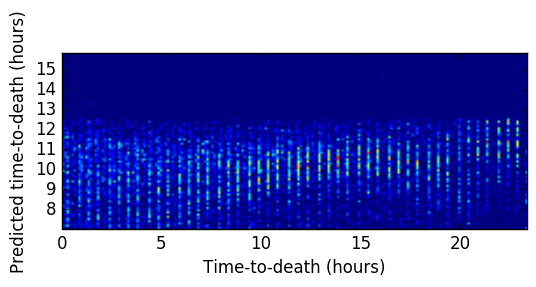

In [280]:
heatmap, xedges, yedges = np.histogram2d(yv, yp, bins=200)
extent = [xedges[0], xedges[-1], yedges[100], yedges[180]]

pt.gcf().set_size_inches(6,4)
pt.xlabel("Time-to-death (hours)")
pt.ylabel("Predicted time-to-death (hours)")
heatmap = heatmap.T
heatmap = heatmap[100:180,:]
pt.imshow(heatmap, extent=extent, origin='lower')

pt.savefig("D:\workspace\msc-thesis-manu\images\svm\pred_heatmap.pdf")

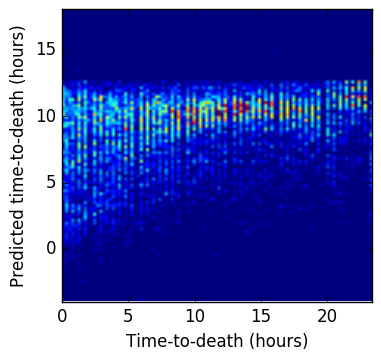

In [279]:
pt.rcParams.update({'font.size': 12})

heatmap, xedges, yedges = np.histogram2d(yv, yp, bins=100, )
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

pt.gcf().set_size_inches(4,4)
pt.xlabel("Time-to-death (hours)")
pt.ylabel("Predicted time-to-death (hours)")
heatmap = heatmap.T
# heatmap = heatmap[50:50,:]
pt.imshow(heatmap, extent=extent, origin='lower')

pt.savefig("D:\workspace\msc-thesis-manu\images\svm\pred_heatmap_full.pdf")

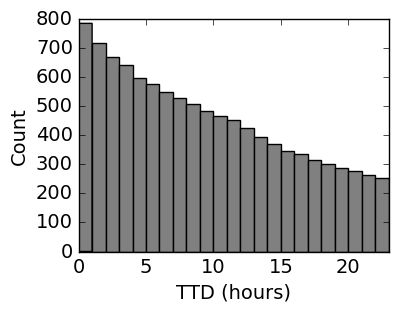

In [281]:
pt.rcParams.update({'font.size': 14})

pt.hist(yv, color="gray", bins=range(int(np.max(yv)) + 1))
pt.xlabel("TTD (hours)")
pt.ylabel("Count")
pt.xlim(0, int(np.max(yv)))
pt.gcf().set_size_inches(4,3)

pt.savefig("D:\workspace\msc-thesis-manu\images\svm\\ttd_dist.pdf")

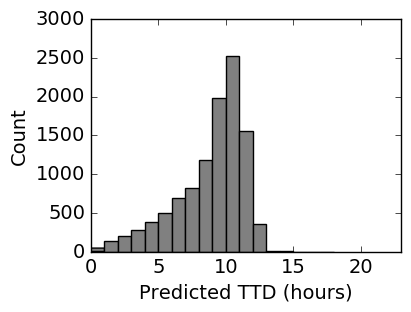

In [277]:
pt.rcParams.update({'font.size': 14})
pt.hist(yp, color="gray", bins=range(int(np.max(yp)) + 1))
pt.xlabel("Predicted TTD (hours)")
pt.ylabel("Count")
pt.xlim(0, int(np.max(yv)))
pt.gcf().set_size_inches(4,3)

pt.savefig("D:\workspace\msc-thesis-manu\images\svm\pred_ttd_dist.pdf")

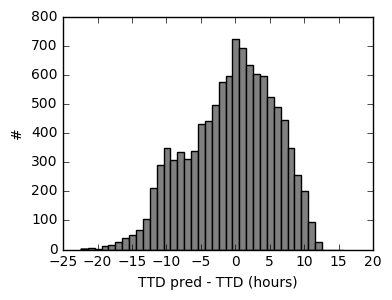

In [236]:
pt.hist(yp - yv, bins=np.arange(np.min(yp - yv), np.max(yp - yv)), color="gray")
pt.ylabel("#")
pt.xlabel("TTD pred - TTD (hours)")
pt.gcf().set_size_inches(4,3)

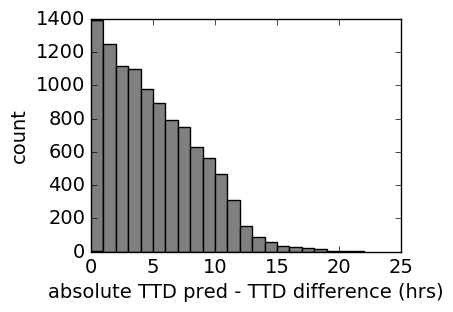

In [276]:
pt.rcParams.update({'font.size': 14})
pt.hist(np.abs(yp - yv), bins=np.arange(np.max(np.abs(yp - yv))), color="gray")
pt.ylabel("count")
pt.xlabel("absolute TTD pred - TTD difference (hrs)")
pt.gcf().set_size_inches(4,3)
pt.savefig("D:\workspace\msc-thesis-manu\images\svm\pred_ttd_absdiff.pdf")

In [264]:
averr = []
avttd = []
avpredttd = []

for i in np.arange(np.floor(y.min()), np.ceil(y.max())):
    lb = i
    ub = i + 1
    sel = (yv < ub) & (yv >= lb)
    yt = yv[sel]
    ypt = yp[sel]
    Xvtt = Xvt.values[sel,:]
    averr.append(np.sum(np.abs(yt - ypt)) / ypt.size)
    avttd.append(np.sum(yt) / ypt.size)
    avpredttd.append(np.sum(ypt) / ypt.size)

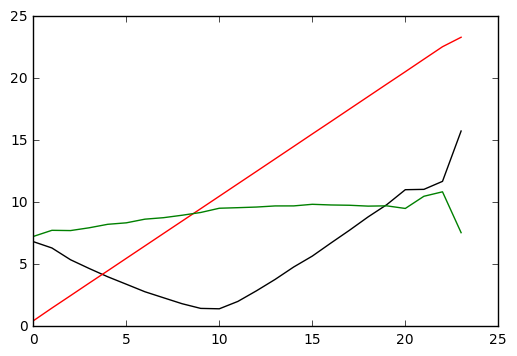

In [265]:
pt.plot(np.arange(np.floor(y.min()), np.ceil(y.max())), averr, c="black")
pt.plot(np.arange(np.floor(y.min()), np.ceil(y.max())), avttd, c="red")
pt.plot(np.arange(np.floor(y.min()), np.ceil(y.max())), avpredttd, c="green")

## 2. Linear

In [164]:
svrl = svm.SVR(kernel='linear', C=1e3, gamma=0.1)
yp = svrl.fit(Xvt, yv).predict(Xvt)
print(svrl.score(Xvt, yv))
print(svrl.coef_)

0.0515104090473
[[-12.99197246  14.92878604  -6.79506127  -0.38706634  21.01911258
   -8.27821586 -52.65048836  -8.01616885  15.23751148 -15.74370295]]


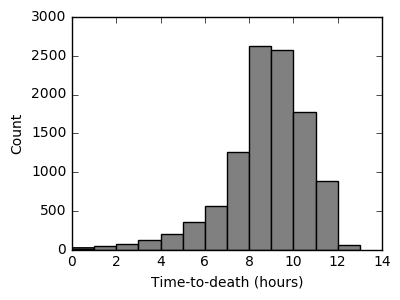

In [157]:
pt.hist(yp, color="gray", bins=range(int(np.max(yp)) + 1))
pt.xlabel("Time-to-death (hours)")
pt.ylabel("Count")
pt.gcf().set_size_inches(4,3)

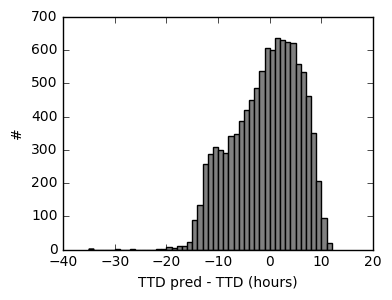

In [158]:
pt.hist(yp - yv, bins=np.arange(np.min(yp - yv), np.max(yp - yv)), color="gray")
pt.ylabel("#")
pt.xlabel("TTD pred - TTD (hours)")
pt.gcf().set_size_inches(4,3)

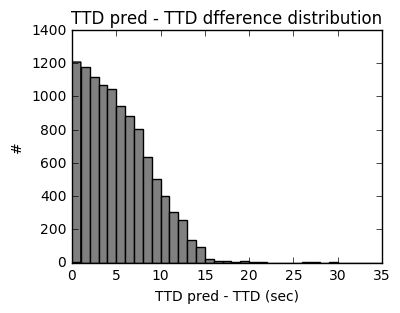

In [159]:
pt.hist(np.abs(yp - yv), bins=np.arange(np.max(np.abs(yp - yv))), color="gray")
pt.title("TTD pred - TTD dfference distribution")
pt.ylabel("#")
pt.xlabel("TTD pred - TTD (sec)")
pt.gcf().set_size_inches(4,3)